# 1. Import

In [1]:
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os
from os.path import basename, dirname, join


import glob
import argparse
import datetime
import random
import json
from netCDF4 import Dataset
import numpy as np

import data_generator
from data_generator import HugoDataGenerator, DataGenerator_sod_f, HugoBinaryGenerator

import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.metrics import (confusion_matrix, 
                            mean_squared_error, 
                            accuracy_score,
                            precision_score,
                            recall_score)
from scipy import stats

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,
                                     Flatten,
                                     Dropout,
                                     BatchNormalization, 
                                     Conv2D, 
                                     MaxPooling2D)
from tensorflow.keras.regularizers import l2

idir = '/Data/preprocessing4hugo/output/'
input_dir_json = '/Data/'

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-eee4v9h_ because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# 2. Definition model

In [3]:
def create_model():
    """ Create sequential CNN with convolutional and dense layers
    
    """
    # number of ice classes
    nbr_classes = 4  
    # size of SAR subimages
    ws = 50
    # size of convolutional filters
    cs = 3
    # number of filters per convolutional layer (x id)
    c1,c2,c3 = 32,32,32
    # number of neurons per hidden neural layer number (x id)
    n1,n2,n3 = 16,16,64
    # value of dropout
    dropout_rate = 0.1
    # value of L2 regularisation
    l2_rate = 0.001

    model = Sequential()

    # Convolutional part
    model.add(BatchNormalization(input_shape=(ws, ws, 2)))
    model.add(Conv2D(c1, (cs, cs), activation='relu'))
    model.add(MaxPooling2D((2, 2),2))
    model.add(Conv2D(c2, (cs, cs), activation='relu'))
    model.add(Conv2D(c3, (cs, cs), activation='relu'))
    model.add(MaxPooling2D((2, 2),2))
    model.add(BatchNormalization())

    model.add(Flatten())

    # Neural network part (hidden layers)
    model.add(Dropout(dropout_rate))
    model.add(Dense(n1, kernel_regularizer=l2(l2_rate), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n2, kernel_regularizer=l2(l2_rate), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n3, kernel_regularizer=l2(l2_rate), activation='relu'))
    model.add(Dropout(dropout_rate))

    # Last neural layer (not hidden)
    model.add(Dense(nbr_classes, kernel_regularizer=l2(l2_rate), activation='softmax'))
    
    return model

# 3. Load Data

### 3.1 Parameters and load files

In [4]:
train_ratio = 0.7
with open(f'{idir}processed_files.json') as fichier_json:
    all_nc = json.load(fichier_json)
npz_files=[]

for nc in all_nc :
    name = nc[:15]
    files = sorted(glob.glob(f'{idir}/{name}/*.npz'))
    npz_files += files
random.shuffle(npz_files)

npz_files = npz_files[:10000]

print('Files number : '+ str (len(npz_files)))
train_files_number = int(len(npz_files) * train_ratio)
train_files = npz_files[:train_files_number]
valid_files = npz_files[train_files_number:]

input_var_names = ['nersc_sar_primary', 'nersc_sar_secondary']
amsr2_var_names = [ 'btemp_6_9h',
                    'btemp_6_9v',
                    'btemp_7_3h',
                    'btemp_7_3v',
                    'btemp_10_7h',
                    'btemp_10_7v',
                    'btemp_18_7h',
                    'btemp_18_7v',
                    'btemp_23_8h',
                    'btemp_23_8v',
                    'btemp_36_5h',
                    'btemp_36_5v',
                    'btemp_89_0h',
                    'btemp_89_0v'
                  ]
 
output_var_name = 'ice_type'
dims_amsr2 = np.load(npz_files[0])[amsr2_var_names[0]].shape

params = {'dims_amsr2':      (*dims_amsr2, len(amsr2_var_names)),
          'idir_json':       input_dir_json,
          'output_var_name': output_var_name,
          'input_var_names': input_var_names,
          'amsr2_var_names': amsr2_var_names,
          'batch_size':      50,
          'shuffle_on_epoch_end': False,
           }

Files number : 10000


### 3.2 processed data for model

In [5]:
training_generator = HugoBinaryGenerator(train_files, **params)
validation_generator = HugoBinaryGenerator(valid_files, **params)

# training_generator = HugoDataGenerator(train_files, **params)
# validation_generator = HugoDataGenerator(valid_files, **params)

# training_generator = DataGenerator_sod_f(train_files, **params)
# validation_generator = DataGenerator_sod_f(valid_files, **params)

print(
     training_generator[0][0].shape, #sar
#     training_generator[0][0][1].shape, #amsr2
     training_generator[0][1].shape, #output
)

(50, 50, 50, 2) (50, 4)


# 4. Load model and trained weights

### 4.1 Load model and trained weights

In [6]:
# creation of the model 
model = create_model()

### 4.2 Apply CNN to SAR data

In [7]:
#callbacks
mc = tf.keras.callbacks.ModelCheckpoint(filepath='hugo_model_1000', 
                                        monitor='val_loss',
                                        verbose=1, 
                                        save_best_only=True,
                                        mode='min')

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#optimizers and compile
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy')

#fit
model.summary()
history = model.fit(training_generator, 
                    use_multiprocessing=True,
                    workers=4,
                    validation_data=validation_generator,
                    epochs=20, 
                    callbacks=[mc, es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 50, 50, 2)        8         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 32)       0

INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 20s 124ms/step - loss: 0.8708 - val_loss: 3.1819
Epoch 2/20
139/140 [============================>.] - ETA: 0s - loss: 0.7743
Epoch 2: val_loss improved from 3.18188 to 0.88820, saving model to hugo_model_1000


INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 9s 65ms/step - loss: 0.7734 - val_loss: 0.8882
Epoch 3/20
140/140 [==============================] - ETA: 0s - loss: 0.7494
Epoch 3: val_loss improved from 0.88820 to 0.68420, saving model to hugo_model_1000


INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 9s 66ms/step - loss: 0.7494 - val_loss: 0.6842
Epoch 4/20
140/140 [==============================] - ETA: 0s - loss: 0.7254
Epoch 4: val_loss improved from 0.68420 to 0.68390, saving model to hugo_model_1000


INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 11s 74ms/step - loss: 0.7254 - val_loss: 0.6839
Epoch 5/20
140/140 [==============================] - ETA: 0s - loss: 0.7041
Epoch 5: val_loss improved from 0.68390 to 0.67472, saving model to hugo_model_1000


INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 9s 65ms/step - loss: 0.7041 - val_loss: 0.6747
Epoch 6/20
140/140 [==============================] - ETA: 0s - loss: 0.6723
Epoch 6: val_loss improved from 0.67472 to 0.65930, saving model to hugo_model_1000


INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 10s 66ms/step - loss: 0.6723 - val_loss: 0.6593
Epoch 7/20
140/140 [==============================] - ETA: 0s - loss: 0.6466
Epoch 7: val_loss improved from 0.65930 to 0.64537, saving model to hugo_model_1000


INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


140/140 [==============================] - 9s 65ms/step - loss: 0.6466 - val_loss: 0.6454
Epoch 8/20
140/140 [==============================] - ETA: 0s - loss: 0.6352
Epoch 8: val_loss did not improve from 0.64537
140/140 [==============================] - 8s 53ms/step - loss: 0.6352 - val_loss: 0.6687
Epoch 9/20
140/140 [==============================] - ETA: 0s - loss: 0.6150
Epoch 9: val_loss did not improve from 0.64537
140/140 [==============================] - 8s 53ms/step - loss: 0.6150 - val_loss: 0.6570
Epoch 10/20
140/140 [==============================] - ETA: 0s - loss: 0.5961
Epoch 10: val_loss did not improve from 0.64537
140/140 [==============================] - 8s 53ms/step - loss: 0.5961 - val_loss: 0.6893


### 4.3 History of loss

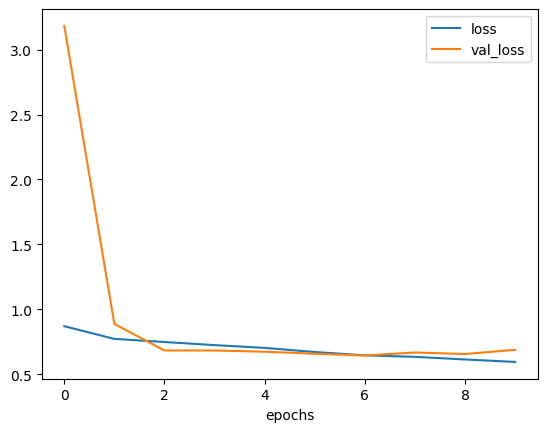

In [8]:
plt.clf()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.legend()
plt.show()


### 4.4 Confusion matrix

60/60 [==============================] - 9s 140ms/step
[[1425    1   61   15]
 [   9   10   31    5]
 [ 243    2  376  197]
 [  18    0   25  163]]


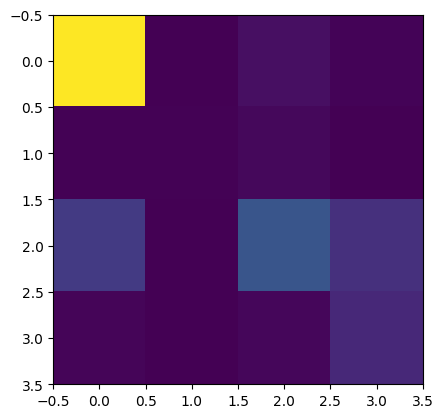

In [9]:
y_pred = model.predict(validation_generator)
y_val = np.vstack([vg[1] for vg in validation_generator])
y_val_index =[]
y_pred_index =[]
for val, pred in zip(y_val, y_pred):
    if max(pred)>0.5 :
        y_val_index.append(np.argmax(val))
        y_pred_index.append(np.argmax(pred))
    
cm = confusion_matrix(y_val_index, y_pred_index)
print(cm)
plt.clf()
plt.imshow(cm)
plt.show()

#### analysis confusion matrix

In [10]:
AC = accuracy_score(y_val_index, y_pred_index)
print ('Accuracy : ' +str(AC))

P_macro = precision_score(y_val_index, y_pred_index, average='macro')
P_micro = precision_score(y_val_index, y_pred_index, average='micro')
print('Precision : ' + str(P_macro)+ " " +str(P_micro))

R_macro = recall_score(y_val_index, y_pred_index, average='macro') 
R_micro = recall_score(y_val_index, y_pred_index, average='micro') 
print('Recall : ' + str(R_macro)+ " " +str(R_micro))

pearson_correlation = stats.pearsonr(y_val_index, y_pred_index)
print(pearson_correlation[0])

rmse = mean_squared_error(y_val_index, y_pred_index)
print(rmse)

Accuracy : 0.764819837272375
Precision : 0.7003908967601525 0.764819837272375
Recall : 0.595368259856343 0.764819837272375
0.7373632741991712
0.6966292134831461


In [11]:
for class_ in range (cm.shape[0]) :
    print('class : '+ str(class_))
    TP = cm[class_][class_]
    print ('TP : '+ str(TP))
    
    M = np.delete(cm, (class_), axis=0)
    M = np.delete(M, (class_), axis=1)
    
    TN =np.sum(M)
    print ('TN : '+ str(TN))
    
    
    lign = cm[0,1:]
    #recuperer la ligne puis supprimer l'element a l'indice class_
#     FP = 
    
    
    
    

class : 0
TP : 1425
TN : 809
class : 1
TP : 10
TN : 2523
class : 2
TP : 376
TN : 1646
class : 3
TP : 163
TN : 2158


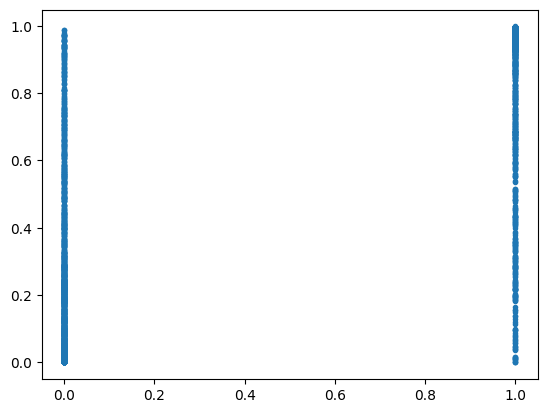

In [12]:
plt.plot(y_val[:,0], y_pred[:,0], '.')
plt.show()

In [13]:

print(cm)
# print (cm[1:,1:])
print(cm[0,1:])
print(cm[1:,0])

# M = np.delete(cm, (2), axis=0)
# M = np.delete(M, (2), axis=1)
# print (M)

[[1425    1   61   15]
 [   9   10   31    5]
 [ 243    2  376  197]
 [  18    0   25  163]]
[ 1 61 15]
[  9 243  18]


In [14]:
from tensorflow import keras
modelbis = keras.models.load_model('/tf/sea_ice_type_cnn_training/asip_v2/hugo_model_test_all/')

In [15]:
y_pred = modelbis.predict(validation_generator)

60/60 [==============================] - 8s 136ms/step


In [16]:
y_val = np.vstack([vg[1] for vg in validation_generator])
y_val_index =[]
y_pred_index =[]
for val, pred in zip(y_val, y_pred):
    if max(pred)>0.5 :
        y_val_index.append(np.argmax(val))
        y_pred_index.append(np.argmax(pred))
    
cm = confusion_matrix(y_val_index, y_pred_index)

In [17]:
print(cm)

[[1426    2  120    3]
 [   3   56   32    8]
 [  89    9  823   77]
 [   6    2   86  153]]
